# Contexto do projeto

In [2]:
from IPython.display import Image

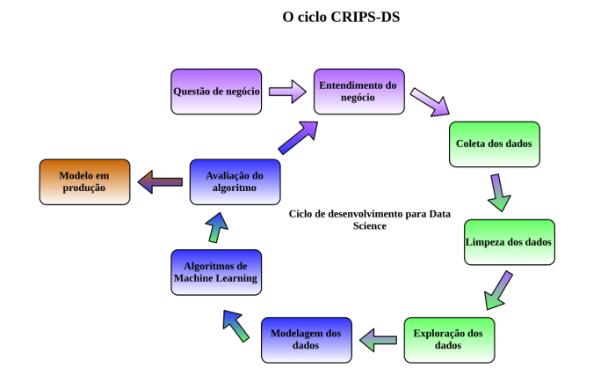

In [3]:
Image(filename='img/img01-mod01-vid04-1.png', width=800)

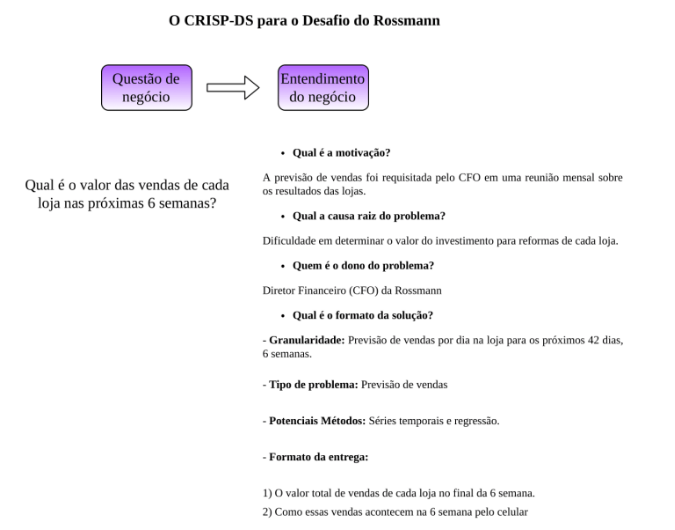

In [4]:
Image(filename='img/img02-mod01-vid04-1.png', width=700)

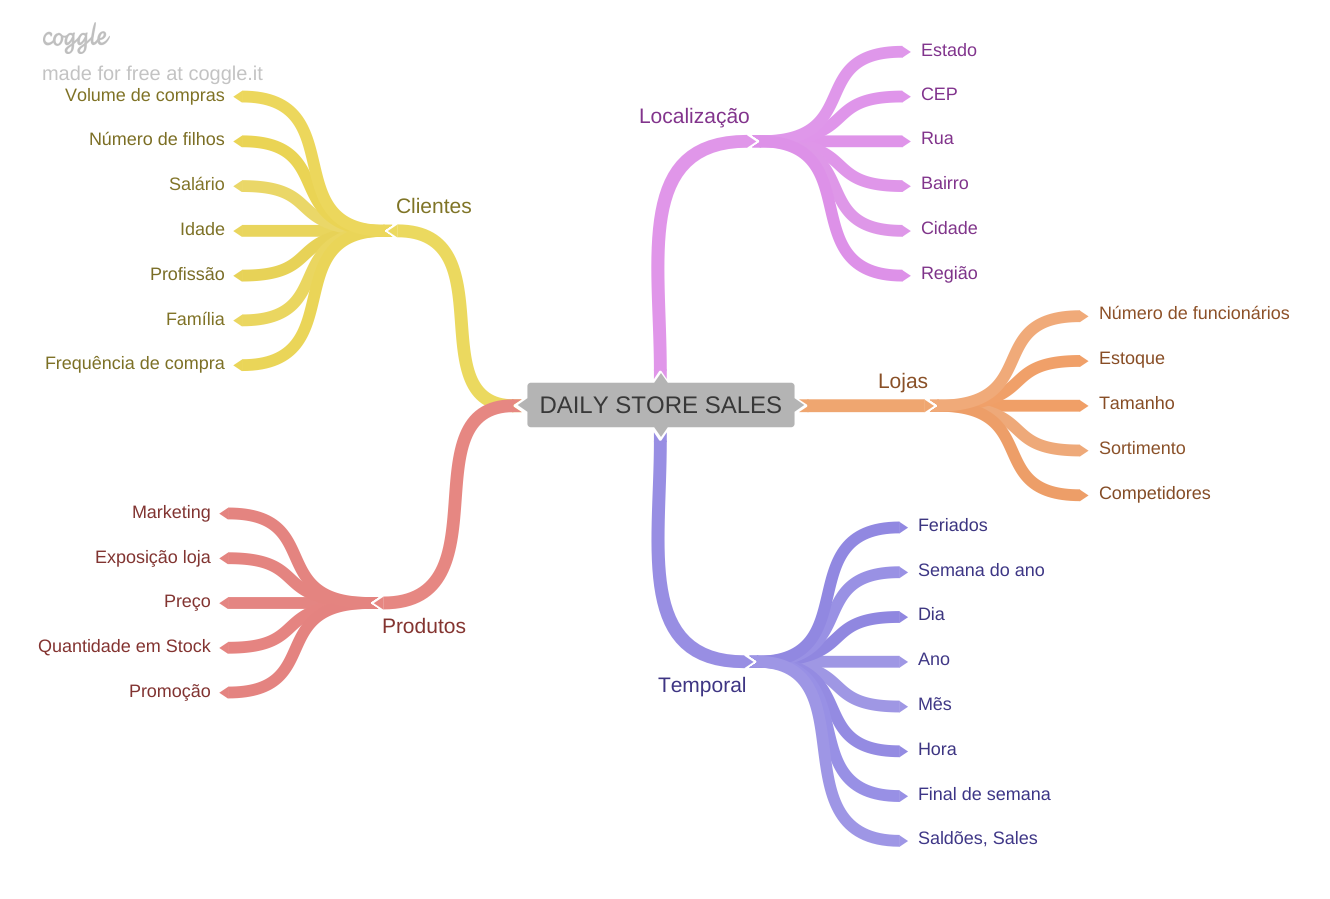

In [5]:
Image(filename='img/mindmap-hipoteses.png')

# 0. Bibliotecas

In [866]:
import warnings
warnings.simplefilter("ignore")

import os
import math
from scipy import stats
from datetime import timedelta
from collections import Counter
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from category_encoders.one_hot import OneHotEncoder

from boruta import BorutaPy

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pre-processing pipelines for models
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin

import inflection
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [7]:
pd.options.display.max_columns = None
sns.set_style(style='whitegrid')

## 0.1. Helper functions

In [8]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    return np.round(np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1))), 4)

In [9]:
def conditional_entropy(X, y):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    :param x: list / NumPy ndarray / Pandas DataFrame
        A sequence of measurements
    :param y: list / NumPy ndarray / Pandas DataFrame
        A sequence of measurements
    :return: float
    """

    # entropy of x given y

    y_counter = Counter(y)

    xy_counter = Counter(list(zip(X, y)))

    total_occurrences = sum(y_counter.values())

    entropy = 0.0

    for xy in xy_counter.keys():

        p_xy = xy_counter[xy] / total_occurrences

        p_y = y_counter[xy[1]] / total_occurrences

        entropy += p_xy * np.log(p_y / p_xy)

    return np.round(entropy, 2)

In [10]:
def sin(x, period):
    return np.sin(x * (2 * np.pi/period))

def cos(x, period):
    return np.cos(x * (2 * np.pi/period))

In [11]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [12]:
def evaluation(y_true, yhat):
    mae = mean_absolute_error(y_true, yhat)
    mape = mean_absolute_percentage_error(y_true, yhat)
    rmse = np.sqrt(mean_squared_error(y_true, yhat))
    mpe = np.mean((y_true - yhat) / y_true) * 100
    
    return  pd.DataFrame({
                    'MAE': np.round(mae, 4),
                    'MAPE': np.round(mape, 4),
                    'RMSE': np.round(rmse, 4),
                    'MPE': np.round(mpe, 4)
                }, index=[0])

## 0.2. Loading data

In [13]:
BASE_DIR = os.path.join(os.path.abspath('..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODELS_DIR = os.path.join(BASE_DIR, 'models')

In [14]:
df_sales_raw = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), low_memory=False)
df_store_raw = pd.read_csv(os.path.join(DATA_DIR, 'store.csv'))

In [659]:
df_store_raw.shape

(1115, 10)

In [15]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1. Data Description

In [16]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [17]:
old_cols = df1.columns.tolist()
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

#rename columns
df1.columns = new_cols

## 1.2. Data Dimensions

In [18]:
print(df_raw.shape[0] , 'Linhas' +  ', ', df_raw.shape[1], 'Colunas')

1017209 Linhas,  18 Colunas


## 1.3. Data type and check NA

In [19]:
exploration = pd.DataFrame({
    'column': df1.columns, 'type': df1.dtypes, 'NA #': df1.isna().sum(), 'NA %': round( (df1.isna().sum() / df1.shape[0]) * 100, 2 )
})

exploration.sort_values('NA %', ascending=False)

,column,type,NA #,NA %
promo_interval,promo_interval,object,508031,49.94
promo2_since_year,promo2_since_year,float64,508031,49.94
promo2_since_week,promo2_since_week,float64,508031,49.94
competition_open_since_year,competition_open_since_year,float64,323348,31.79
competition_open_since_month,competition_open_since_month,float64,323348,31.79
competition_distance,competition_distance,float64,2642,0.26
day_of_week,day_of_week,int64,0,0.00
promo2,promo2,int64,0,0.00
assortment,assortment,object,0,0.00
store,store,int64,0,0.00


In [20]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Fillout NA

In [21]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month']
, axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year']
, axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week']
, axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year']
, axis=1)

# promo_interval
df1['promo_interval'].fillna(0, inplace=True)

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int32)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int32)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int32)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int32)

## 1.5. Descriptive Statistical

In [23]:
num_features = df1.select_dtypes(include=np.number)
cat_features = df1.select_dtypes(include=np.object)

### 1.5.1 Numerical features

In [24]:
num_features.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


In [25]:
pd.DataFrame({
    'skew': num_features.apply(lambda x: x.skew()).tolist(),
    'kutosis': num_features.apply(lambda x: x.kurtosis()).tolist()
}, index=num_features.columns.tolist())

,skew,kutosis
store,-0.000955,-1.200524
day_of_week,0.001593,-1.246873
sales,0.641460,1.778375
customers,1.598650,7.091773
open,-1.758045,1.090723
promo,0.487838,-1.762018
school_holiday,1.677842,0.815154
competition_distance,10.242344,147.789712
competition_open_since_month,-0.042076,-1.232607
competition_open_since_year,-7.235657,124.071304


### 1.5.2 Categorical features

In [26]:
cat_features.nunique()

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

In [27]:
%matplotlib widget
filter1 = df1.loc[ (df1['state_holiday'] != '0') & (df1['sales'] > 0) ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=filter1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=filter1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=filter1)

plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# 2. Levantamento de hipóteses

In [28]:
df2 = df1.copy()

## 2.1 Create hypotheses

### 2.1.1 Store Hypotheses

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2 Product Hypotheses

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas maior exposição de produtos deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (desconto maiores), deveriam dender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Time Hypotheses

**1.** Em dias de feriados as lojas de menor porte vendem menos.

**2.** As lojas de porte médio vender menos no período da tarde.

**3.** Lojas abertas durante o feriado de natal deveriam vender mais.

**4.** Lojas deveriam vender mais ao longo do ano.

**5.** Lojas deveriam vender mais no segundo semestre do ano.

**6.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**7.** Lojas deveriam vender menos aos finais de semana.

**8.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 List of Hypotheses

### Store

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### Product

**4.** Lojas com promoções mais agressivas (desconto maiores), deveriam dender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

### Time

**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo do ano.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

# 3. Filtragem de variáveis

In [29]:
df3 = df2.copy()

## 3.1 Filtragem por linhas

1. open != 0 -> Removemos os regitros cuja a loja encontra-se fechada, pois loja fechada não tem venda

In [30]:
df3 = df3.loc[df3['open'] != 0]
df3.shape

(844392, 18)

## 3.2 Filtragem por colunas

1. customers -> Quantidade de vendas dos clientes referente ao dia. No contexto desse projet, não temos como dizer quantos customers vai ter a N dia/semana/mês a frente. Por isso não podemos usá-la no modelo, pois não a teremos no momento da predição

2. Open -> Possue apenas o valor 1, que significa loja aberta.

3. promo_interval -> Intervalo de duração de uma determinada promoção. Vale sua remoção, pois usamos essa variável para obter outro mais intuitiva ao nosso problema de negócio.

4. month -> Apenas capturamos os meses das datas

In [31]:
cols_drop = ['customers', 'open']
df3.drop(columns=cols_drop, axis=1, inplace=True)
df3.shape

(844392, 16)

# 4. Featute Engineering

In [32]:
df4_1 = df3.copy()

## Feature engineering

In [226]:
def feature_engineering(df: pd.DataFrame()) -> pd.DataFrame:
    
    data = df.copy()
    
    months = {
        1: 'jan',
        2: 'fev',
        3: 'mar',
        4: 'apr',
        5: 'may',
        6: 'jun',
        7: 'jul',
        8: 'aug',
        9: 'sep',
        10: 'oct',
        11: 'nov',
        12: 'dec'
    }
    

    # year
    data['year'] = data['date'].dt.year

    # month
    data['month'] = data['date'].dt.month

    # day
    data['day'] = data['date'].dt.day

    # week of year
    data['week_of_year'] = data['date'].dt.isocalendar().week.astype(np.int32)

    # year week
    data['year_week'] = data['date'].dt.strftime('%Y-%W')

    # competition since
    data['competition_since'] = data.apply(
        lambda x: datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1)
    , axis=1)

    data['competition_time_month'] = ((data['date'] - data['competition_since'])/30).apply(lambda x: x.days).astype(np.int)

    # promo since
    data['promo_since'] = data['promo2_since_year'].astype(str) + '-' + data['promo2_since_week'].astype(str)
    data['promo_since'] = data['promo_since'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
    data['promo_time_week'] = ((data['date'] - data['promo_since'])/7).apply(lambda x: x.days).astype(np.int)

    # assortment
    data['assortment'] = data['assortment'].map({'a': 'basic', 'b': 'extra', 'c': 'extended'})

    # state holiday
    data['state_holiday'] = data['state_holiday'].map({'a': 'public holiday', 'b': 'Easter holiday', 'c': 'Christimas', '0': 'regular day'})
    

    #is_promo
    data['cat_month'] = data['date'].dt.month.map(months)
    
    data['is_promo'] = data[['promo_interval', 'cat_month']].apply(
        lambda x: 0 if x['promo_interval'] == 0 else 1 if x['cat_month'] in x['promo_interval'].lower().split(',') else 0
    , axis=1)
    
    data = data.drop(['promo_interval', 'cat_month'], axis=1)
    
    return data

In [34]:
df4_1 = feature_engineering(df4_1)

## Transformação de nature nas variáveis temporais

In [35]:
def nature_transformation(df: pd.DataFrame()) -> pd.DataFrame:
    
    data = df.copy()
    
    # day of week
    data['day_of_week_sin'] = data['day_of_week'].apply(lambda x: sin(x, 7))
    data['day_of_week_cos'] = data['day_of_week'].apply(lambda x: cos(x, 7))

    #month
    data['month_sin'] = data['month'].apply(lambda x: sin(x, 12))
    data['month_cos'] = data['month'].apply(lambda x: cos(x, 12))

    # day
    data['day_sin'] = data['day'].apply(lambda x: sin(x, 30))
    data['day_cos'] = data['day'].apply(lambda x: cos(x, 30))

    # week of year
    data['week_of_year_sin'] = data['week_of_year'].apply(lambda x: sin(x, 52))
    data['week_of_year_cos'] = data['week_of_year'].apply(lambda x: cos(x, 52))
    
    return data

In [36]:
df4_1 = nature_transformation(df4_1)

# 6. Análise exploratória dos dados

In [37]:
df4 = df4_1.copy()

## 4.1. Analise univariada

### 4.1.1. Variável dependente

In [38]:
%matplotlib widget
sns.histplot(df4['sales'], kde=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### 4.1.2. Variáveis independentes (Quantitativas)

In [39]:
%matplotlib widget
num_features.hist(figsize=(12, 6))
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### 4.1.2. Variáveis independentes (Qualitativas)

In [40]:
%matplotlib widget

# state_holiday
plt.subplot(3, 2, 1)
filter1 = df4.loc[df4['state_holiday'] != 'regular day']
sns.countplot(x='state_holiday', data=filter1)

plt.subplot(3, 2, 2)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'public holiday', 'sales'], label='public holiday', shade=True)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'Easter holiday', 'sales'], label='Easter holiday', shade=True)
sns.kdeplot(df4.loc[df4['state_holiday'] == 'Christimas', 'sales'], label='Christimas', shade=True)

plt.legend()
plt.tight_layout()
plt.show()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3, 2, 4)
sns.kdeplot(df4.loc[df4['store_type'] == 'a', 'sales'], label='a', shade=True)
sns.kdeplot(df4.loc[df4['store_type'] == 'b', 'sales'], label='b', shade=True)
sns.kdeplot(df4.loc[df4['store_type'] == 'c', 'sales'], label='c', shade=True)
sns.kdeplot(df4.loc[df4['store_type'] == 'd', 'sales'], label='d', shade=True)

plt.legend()
plt.tight_layout()
plt.show()

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3, 2, 6)
sns.kdeplot(df4.loc[df4['assortment'] == 'extended', 'sales'], label='extended', shade=True)
sns.kdeplot(df4.loc[df4['assortment'] == 'basic', 'sales'], label='basic', shade=True)
sns.kdeplot(df4.loc[df4['assortment'] == 'extra', 'sales'], label='extra', shade=True)

plt.legend()
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 4.2. Analise bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.
**VERDADE** Lojas com maior sortimento vendem MAIS

In [478]:
%matplotlib widget
filter2 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=filter2)

filter3 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
filter3.pivot(index='year_week', columns='assortment', values='sales').plot()

( filter3
 .loc[filter3['assortment'] == 'extra']
 .pivot(index='year_week', columns='assortment', values='sales')
 .plot() )

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [42]:
df4['assortment'].value_counts(normalize=True)

basic       0.526899
extended    0.463376
extra       0.009725
Name: assortment, dtype: float64

In [43]:
( df4
 .groupby('assortment')
 .agg({'sales': 'sum'}) / df4['sales'].sum() * 100 ).reset_index()

,assortment,sales
0,basic,50.155959
1,extended,48.636070
2,extra,1.207971


In [44]:
%matplotlib widget
(df4
 .groupby('assortment')
 .agg({'sales': 'sum'}) / df4['sales']
 .sum() * 100).plot(kind='bar')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais próximos vendem MAIS

In [45]:
filter4 = ( df4[['competition_distance', 'sales']]
           .groupby('competition_distance')
           .agg({'sales': 'sum'})
           .reset_index() )

%matplotlib widget
sns.scatterplot(x='competition_distance', y='sales', data=filter4)
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
bins = list(np.arange(19, 200000, 10000))
filter4['competition_distance_binned'] = pd.cut(filter4['competition_distance'], bins=bins)

%matplotlib widget
filter5 = ( filter4[['competition_distance_binned', 'sales']]
           .groupby('competition_distance_binned')
           .agg({'sales': 'sum'})
           .reset_index() )
sns.barplot(x='competition_distance_binned', y='sales', data=filter5)
plt.xticks(rotation=30)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [47]:
%matplotlib widget
sns.heatmap(filter4.corr(), annot=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### **H3.** Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com competidores à mais tempo vendem MENOS

In [48]:
filter6 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').agg({'sales': 'sum'}).reset_index()

bins = list(np.arange(-33, 1407, 50))
filter6['competition_time_month_binned'] = pd.cut(filter6['competition_time_month'], bins=bins)

%matplotlib widget
filter7 = ( filter6[['competition_time_month_binned', 'sales']]
           .groupby('competition_time_month_binned')
           .agg({'sales': 'sum'})
           .reset_index() )
sns.barplot(x='competition_time_month_binned', y='sales', data=filter7)
plt.xticks(rotation=30)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
%matplotlib widget
f = filter6.loc[(filter6['competition_time_month'] < 120) & (filter6['competition_time_month'] != 0)]
sns.regplot(x='competition_time_month', y='sales', data=f)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [50]:
%matplotlib widget
sns.heatmap(filter6[['competition_time_month', 'sales']].corr(), annot=True)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### <s>H4. Lojas com promoções mais agressivas (desconto maiores), deveriam vender mais.</s>

### H5. Lojas com promoções ativas por mais tempo deveriam vender mais.
**VERDADE** Lojas com promoções ativas por mais tempo vendem MAIS, embora a diferença de vendas entre as menos ativas sejam bem sutis.

In [51]:
%matplotlib widget

filter8 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').agg({'sales': 'sum'}).reset_index()

bins = list(np.arange(-125, 314, 20))
filter8['promo_time_week_binned'] = pd.cut(filter8['promo_time_week'], bins=bins)

sns.barplot(x='promo_time_week_binned', y='sales', data=filter8)
plt.xticks(rotation=60)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Embora as promoções consecutivas demonstrem vender menos, não temos provas suficiente para confirmar um evento maior, e condizer com precisão que vendem MAIS OU MENOS. 

In [52]:
( ( df4[['promo', 'promo2', 'sales']]
 .groupby(['promo', 'promo2'])
 .agg({'sales': 'sum'}) / df4['sales'].sum() * 100)
 .reset_index()
 .sort_values('sales', ascending=False) )

,promo,promo2,sales
2,1,0,27.735066
0,0,0,25.243768
3,1,1,25.067776
1,0,1,21.953390


In [53]:
%matplotlib widget

mask10 = (df4['promo'] == 1) & (df4['promo2'] == 1)
filter10 = ( ( df4
            .loc[mask10][['year_week', 'sales']]
            .groupby('year_week')
            .agg({'sales': 'sum'}) / df4.loc[mask10, 'sales'].sum() * 100 )
            .reset_index() )
ax = filter10.plot()


mask11 = (df4['promo'] == 1) & (df4['promo2'] == 0)
filter11 = ( ( df4
            .loc[mask11][['year_week', 'sales']]
            .groupby('year_week')
            .agg({'sales': 'sum'}) / df4.loc[mask11, 'sales'].sum() * 100 )
            .reset_index() )

ax2 = filter11.plot(ax=ax)
ax.set_title('Vendas com promoção TRADICIONAL & EXTENDIDA vs TRADICIONAL')
ax.legend(labels=['TRADICIONAL & EXTENDIDA', 'TRADICIONAL'])

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [54]:
%matplotlib widget

mask10 = (df4['promo'] == 0) & (df4['promo2'] == 0)
filter10 = ( ( df4
            .loc[mask10][['year_week', 'sales']]
            .groupby('year_week')
            .agg({'sales': 'sum'}) / df4.loc[mask10, 'sales'].sum() * 100 )
            .reset_index() )
ax = filter10.plot()


mask11 = (df4['promo'] == 0) & (df4['promo2'] == 1)
filter11 = ( ( df4
            .loc[mask11][['year_week', 'sales']]
            .groupby('year_week')
            .agg({'sales': 'sum'}) / df4.loc[mask11, 'sales'].sum() * 100 )
            .reset_index() )

ax2 = filter11.plot(ax=ax)
ax.set_title('Vendas sem PROMOÇÃO vs EXTENDIDA ')
ax.legend(labels=['SEM PROMOÇÃO', 'EXTENDIDA'])

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [55]:
filter10

,year_week,sales
0,2013-00,0.934664
1,2013-01,0.216890
2,2013-02,1.228972
3,2013-03,0.208325
4,2013-04,1.356164
...,...,...
131,2015-25,1.355744
132,2015-26,0.224417
133,2015-27,1.478705
134,2015-28,0.237452


### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de natal vende MENOS

In [56]:
%matplotlib widget
filter12 = ( ( df4[['state_holiday', 'sales']]
               .loc[df4['state_holiday'] != 'regular day']
               .groupby('state_holiday')
               .agg({'sales': 'sum'}) / df4['sales'].sum() * 100 )
               .round(2) ).reset_index()

sns.barplot(x='state_holiday', y='sales', data=filter12)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [57]:
%matplotlib widget
filter13 = ( ( df4[['year', 'state_holiday', 'sales']]
               .loc[df4['state_holiday'] != 'regular day']
               .groupby(['year', 'state_holiday'])
               .agg({'sales': 'sum'}) / df4['sales'].sum() * 100 )
               .round(2) ).reset_index()

sns.barplot(x='year', y='sales', hue='state_holiday', data=filter13)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### **H8.** Lojas deveriam vender mais ao longo do ano.
**FALSA** Lojas vendem MENOS ao longo dos anos

In [58]:
%matplotlib widget
filter14 = ( (df4[['year', 'sales']]
             .groupby('year')
             .agg({'sales': 'sum'}) / df4['sales'].sum() * 100)
             .reset_index() )

sns.barplot(x='year', y='sales', data=filter14)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [59]:
filter14

,year,sales
0,2013,39.210033
1,2014,37.131582
2,2015,23.658384


In [60]:
%matplotlib widget
filter14 = ( (df4[['year', 'sales']]
             .groupby('year')
             .agg({'sales': 'sum'}) / df4['sales'].sum() * 100)
             .reset_index() )

sns.regplot(x='year', y='sales', data=filter14)
plt.xticks([2013, 2014, 2015])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem MENOS no segundo semestre do ano

In [61]:
%matplotlib widget
month_map = {
    1: 'jan',
    2: 'fev',
    3: 'mar',
    4: 'abr',
    5: 'mai',
    6: 'jun',
    7: 'jul',
    8: 'ago',
    9: 'set',
    10: 'out',
    11: 'nov',
    12: 'dez'
}

filter15 = ( (df4[['month', 'sales']]
             .groupby('month')
             .agg({'sales': 'sum'}) / df4['sales'].sum() * 100)
             .reset_index() )

filter15['month'] = filter15['month'].map(month_map)

sns.barplot(x='month', y='sales', data=filter15)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

In [62]:
filter16 = ( (df4[['day', 'sales']]
             .groupby('day')
             .agg({'sales': 'sum'}) / df4['sales'].sum() * 100)
             .reset_index() )


In [63]:
# Vendas até o dia 10
filter16.loc[filter16['day'] <= 10, 'sales'].sum()

33.549203395578935

In [64]:
# Vendas até o dia 10
filter16.loc[filter16['day'] > 10, 'sales'].sum()

66.45079660442107

In [65]:
%matplotlib widget
sns.barplot(x='day', y='sales', data=filter16)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO** Lojas vendem MENOS aos finais de semana

In [66]:
%matplotlib widget
day_map = {
    1: 'seg',
    2: 'ter',
    3: 'qua',
    4: 'qui',
    5: 'sex',
    6: 'sab',
    7: 'dom',
}

filter17 = ( (df4[['day_of_week', 'sales']]
             .groupby('day_of_week')
             .agg({'sales': 'sum'}) / df4['sales'].sum() * 100)
             .reset_index() )

filter17['day_of_week'] = filter17['day_of_week'].map(day_map)

sns.barplot(x='day_of_week', y='sales', data=filter17)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA**Lojas vendem MENOS durante os feriados escolares, exceto o mês de julho.

In [67]:
%matplotlib widget
month_map = {
    1: 'jan',
    2: 'fev',
    3: 'mar',
    4: 'abr',
    5: 'mai',
    6: 'jun',
    7: 'jul',
    8: 'ago',
    9: 'set',
    10: 'out',
    11: 'nov',
    12: 'dez'
}

filter18 = ( (df4[['school_holiday', 'sales']]
             .groupby('school_holiday')
             .agg({'sales': 'sum'}) / df4['sales'].sum() * 100)
             .reset_index() )

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=filter18)

filter19 = ( (df4[['month', 'school_holiday', 'sales']]
             .groupby(['month', 'school_holiday'])
             .agg({'sales': 'sum'}) / df4['sales'].sum() * 100)
             .reset_index() )

filter19['month'] = filter19['month'].map(month_map)

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=filter19)

plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 4.3. Resumo das hipóteses

Hipóteses | Conclusão | Relevância
--------- | --------- | ----------
H1 | Verdade | Baixa
H2 | Falsa | Média
H3 | Falsa | Média
H4 | - | -
H5 | Verdade | Baixa
H6 | Falsa | Média
H7 | Falsa | Alta
H8 | Falsa | Alta
H9 | Falsa | Alta
H10 | Verdade | Alta
H11 | Verdade | Alta
H12 | Verdade | Baixa

## 4.4. Analise multivariada

### 4.4.1. Variáveis quantitativas 

In [68]:
%matplotlib widget
sns.heatmap(df4.select_dtypes(include=np.number).corr(), annot=True, fmt='.2f')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### 4.4.2. Variáveis qualitativas 

In [69]:
cat_features_v2 = df4.select_dtypes(include='object')

In [70]:
c1 = cramer_v(cat_features_v2['state_holiday'], cat_features_v2['state_holiday'])
c2 = cramer_v(cat_features_v2['state_holiday'], cat_features_v2['store_type'])
c3 = cramer_v(cat_features_v2['state_holiday'], cat_features_v2['assortment'])

c4 = cramer_v(cat_features_v2['store_type'], cat_features_v2['state_holiday'])
c5 = cramer_v(cat_features_v2['store_type'], cat_features_v2['store_type'])
c6 = cramer_v(cat_features_v2['store_type'], cat_features_v2['assortment'])

c7 = cramer_v(cat_features_v2['assortment'], cat_features_v2['state_holiday'])
c8 = cramer_v(cat_features_v2['assortment'], cat_features_v2['store_type'])
c9 = cramer_v(cat_features_v2['assortment'], cat_features_v2['assortment'])

df_corr_cramer = pd.DataFrame({
    'state_holiday': [c1, c2, c3],
    'store_type': [c4, c5, c6],
    'assortment': [c7, c8, c9]
}, index=['state_holiday', 'store_type', 'assortment' ])

df_corr_cramer

,state_holiday,store_type,assortment
state_holiday,1.0000,0.0711,0.0675
store_type,0.0711,1.0000,0.5385
assortment,0.0675,0.5385,1.0000


In [71]:
%matplotlib widget
sns.heatmap(df_corr_cramer, annot=True)
plt.title('Cramer V')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [72]:
c1 = conditional_entropy(cat_features_v2['state_holiday'], cat_features_v2['state_holiday'])
c2 = conditional_entropy(cat_features_v2['state_holiday'], cat_features_v2['store_type'])
c3 = conditional_entropy(cat_features_v2['state_holiday'], cat_features_v2['assortment'])

c4 = conditional_entropy(cat_features_v2['store_type'], cat_features_v2['state_holiday'])
c5 = conditional_entropy(cat_features_v2['store_type'], cat_features_v2['store_type'])
c6 = conditional_entropy(cat_features_v2['store_type'], cat_features_v2['assortment'])

c7 = conditional_entropy(cat_features_v2['assortment'], cat_features_v2['state_holiday'])
c8 = conditional_entropy(cat_features_v2['assortment'], cat_features_v2['store_type'])
c9 = conditional_entropy(cat_features_v2['assortment'], cat_features_v2['assortment'])


df_corr_cond_entropy = pd.DataFrame({
    'state_holiday': [c1, c2, c3],
    'store_type': [c4, c5, c6],
    'assortment': [c7, c8, c9]
}, index=['state_holiday', 'store_type', 'assortment'])

df_corr_cond_entropy

,state_holiday,store_type,assortment
state_holiday,0.00,1.04,0.74
store_type,0.01,0.00,0.67
assortment,0.01,0.97,0.00


In [73]:
%matplotlib widget
sns.heatmap(df_corr_cond_entropy, annot=True)
plt.title('Conditional Entropy')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# 7. Modelagem dos dados

In [74]:
df5 = df4.copy()

## Separação dos dados em treino e teste

In [75]:
fit_features = [
     'store',
     'promo',
     'state_holiday',
     'school_holiday',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'is_promo',
     'year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos'
]

In [76]:
df5[['store', 'date']].groupby('store').max().reset_index()['date'][0] - timedelta(days=42)

Timestamp('2015-06-19 00:00:00')

In [77]:
X_tr, y_tr = df5.loc[df5['date'] < '2015-06-19', fit_features], df5.loc[df5['date'] < '2015-06-19', 'sales']
X_ts, y_ts = df5.loc[df5['date'] >= '2015-06-19', fit_features], df5.loc[df5['date'] >= '2015-06-19', 'sales']

In [78]:
X_train, y_train = X_tr.copy(), y_tr.copy()
X_test, y_test = X_ts.copy(), y_ts.copy()

In [79]:
df5.columns[~df5.columns.isin(X_test.columns.tolist())]

Index(['day_of_week', 'date', 'sales', 'month', 'day', 'week_of_year',
       'year_week', 'competition_since', 'promo_since'],
      dtype='object')

## Scaling

In [80]:
num_cols = (X_tr
            .select_dtypes(include=np.number)
            .columns
            .tolist())

In [81]:
for col in num_cols:
    if col not in ['promo', 'promo2', 'is_promo', 'school_holiday']:
        scaler = RobustScaler().fit(X_train[col].values.reshape(-1, 1))
        
        X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
        X_test[col] = scaler.fit_transform(X_test[col].values.reshape(-1, 1))

## Encoding

In [82]:
cat_cols = df5[fit_features].select_dtypes(include=np.object).columns.tolist()

In [83]:
one_hot = OneHotEncoder(cols=cat_cols, use_cat_names=True).fit(X_train, y_train)

X_train = one_hot.transform(X_train, y_train)
X_test = one_hot.transform(X_test, y_test)

## Transformações

### Transformação da variável dependente

In [84]:
y_train = np.cbrt(y_train)

# 8. Seleção de variáveis

In [85]:
df6 = df5.copy()

## Boruta

In [87]:
rf = RandomForestRegressor(n_jobs=-1)
boruta = ( BorutaPy(rf, n_estimators='auto', max_iter=50, verbose=2, random_state=25)
           .fit(X_train.values, y_train.values) )

Iteration: 	1 / 50
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 50
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 50
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 50
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 50
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 50
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 50
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 50
Confirmed: 	20
Tentative: 	1
Rejected: 	11
Iteration: 	9 / 50
Confirmed: 	20
Tentative: 	1
Rejected: 	11
Iteration: 	10 / 50
Confirmed: 	20
Tentative: 	1
Rejected: 	11
Iteration: 	11 / 50
Confirmed: 	20
Tentative: 	1
Rejected: 	11
Iteration: 	12 / 50
Confirmed: 	20
Tentative: 	1
Rejected: 	11
Iteration: 	13 / 50
Confirmed: 	20
Tentative: 	1
Rejected: 	11
Iteration: 	14 / 50
Confirmed: 	20
Tentative: 	1
Rejected: 	11
Iteration: 	15 / 50
Confirmed: 	20
Tentative: 	1
Rejected: 	11
Iteration: 	16 / 50
Confirmed: 	20
Tentative: 	1
Rejected: 	11
Iteratio

In [93]:
features = X_train.columns.tolist()
features_selected = list()

indexes = np.where(boruta.support_ == True)

for x in np.nditer(indexes):
    features_selected.append(features[x])

print(features_selected)

['store', 'promo', 'store_type_c', 'store_type_a', 'store_type_d', 'store_type_b', 'assortment_extended', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos']


In [86]:
features_selected = [
    'store', 'promo', 'store_type_c', 
    'store_type_a', 'store_type_d', 'store_type_b', 
    'assortment_extended', 'competition_distance', 
    'competition_open_since_month', 'competition_open_since_year', 
    'promo2', 'promo2_since_week', 'promo2_since_year', 
    'competition_time_month', 'promo_time_week', 
    'day_of_week_sin',
    'day_of_week_cos', 
    'month_sin', 
    'month_cos', 
    'day_sin', 
    'day_cos',
    'week_of_year_sin', 
    'week_of_year_cos'
]

features_selected_cv = [
    'store',
    'promo',
    'state_holiday', 
    'store_type', 
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos', 
    'month_sin', 
    'month_cos', 
    'day_sin', 
    'day_cos',
    'week_of_year_sin', 
    'week_of_year_cos'
]

# 9. Machine learning

In [88]:
df7 = df6.copy()

## Modelo baseline

In [91]:
x_baseline = X_test[features_selected].copy()
x_baseline['sales'] = y_test.copy()

xx_baseline = x_baseline[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'pred'})
xxx_baseline = pd.merge(x_baseline, xx_baseline, how='left', on='store')

y_hat_baseline = xxx_baseline['pred']

evaluation(y_test, y_hat_baseline)

,MAE,MAPE,RMSE,MPE
0,1370.9611,21.6985,1817.7475,-16.7271


## Cross-validation

### Manual

In [152]:
X_train_m = X_train[features_selected].copy()

In [153]:
idx_train = X_train_m.index

In [154]:
X_train_m[['date', 'sales']] = df6.loc[idx_train, ['date', 'sales']]

In [156]:
def cross_validation_ts(X, estimator, n_splits=5, verbose=True) -> pd.DataFrame:
    
    
    X = X.copy()
    
    metrics = {'MAE': [], 'MAPE': [], 'RMSE': []}
    
    for k in range(1, n_splits+1):
        if verbose:
            print(f'Kfold {k}')
        
        # Fatiamento de 6 semanas
        validation_start_date = X['date'].max() - timedelta(days=k*6*7)
        validation_end_date = X['date'].max() - timedelta(days=(k-1)*6*7)
        
        # Divisão dos dados de treino e validação
        train = X[X['date'] < validation_start_date]
        val = X[(X['date'] >= validation_start_date) & (X['date'] <= validation_end_date)]
        
        # Remove a coluna de date e sales dos dados
        X_train = train.drop(['date', 'sales'], axis=1)
        y_train = np.cbrt(train['sales'])
        
        X_val = val.drop(['date', 'sales'], axis=1)
        y_val = val['sales']
        
        # Treina o modelo
        model = estimator.fit(X_train, y_train)
        
        # Previsões das vendas
        yhat = model.predict(X_val)
        
        # Métricas de avaliação
        result = evaluation(y_val, yhat ** 3)
        
        metrics['MAE'].extend(result['MAE'].values.tolist())
        metrics['MAPE'].extend(result['MAPE'].values.tolist())
        metrics['RMSE'].extend(result['RMSE'].values.tolist())
        
    return pd.DataFrame({
        'model': estimator.__class__.__name__,
        'MAE CV': np.round(np.mean(metrics['MAE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['MAE']), 4).astype(str),
        'MAPE CV': np.round(np.mean(metrics['MAPE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['MAPE']), 4).astype(str),
        'RMSE CV': np.round(np.mean(metrics['RMSE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['RMSE']), 4).astype(str)
    }, index=[0])

In [157]:
estimators = [
    LinearRegression(),
    Lasso(),
    RandomForestRegressor(),
    xgb.XGBRegressor()
]

results = []

for estimator in estimators:
    results.append(cross_validation_ts(X_train_m, estimator, n_splits=5, verbose=False))

In [158]:
df_results = pd.concat(results)

In [92]:
df_results

,model,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,2065.5298 +/- 273.8264,30.8087 +/- 1.8952,2884.8139 +/- 444.1284
0,Lasso,2368.7897 +/- 372.0833,34.5405 +/- 1.2491,3318.2597 +/- 543.8229
0,RandomForestRegressor,846.9082 +/- 199.327,11.9217 +/- 2.1954,1275.5469 +/- 280.3668
0,XGBRegressor,1044.1866 +/- 145.3391,15.0551 +/- 1.6234,1462.3425 +/- 183.1668


### Time Series Split

In [92]:
def cross_validation_ts_split(X, y, estimator, **kwargs):
    
    X = X.copy()
    
    kfold_ts = TimeSeriesSplit(**kwargs)
    
    metrics = {'MAE': [], 'MAPE': [], 'RMSE': []}

    for train_idx, val_idx in kfold_ts.split(X[features_selected]):
        
        # Separa os dados entre treino e validação
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Treina o modelo
        model = estimator.fit(X_train, y_train)
        
        # Previsões das vendas
        yhat = model.predict(X_val)
        
        # Métricas de avaliação
        result = evaluation(y_val ** 3, yhat ** 3)
        
        metrics['MAE'].extend(result['MAE'].values.tolist())
        metrics['MAPE'].extend(result['MAPE'].values.tolist())
        metrics['RMSE'].extend(result['RMSE'].values.tolist())
        
    return pd.DataFrame({
        'model': estimator.__class__.__name__,
        'MAE CV': np.round(np.mean(metrics['MAE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['MAE']), 4).astype(str),
        'MAPE CV': np.round(np.mean(metrics['MAPE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['MAPE']), 4).astype(str),
        'RMSE CV': np.round(np.mean(metrics['RMSE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['RMSE']), 4).astype(str)
    }, index=[0])

In [93]:
estimators_v2 = [
    LinearRegression(),
    Lasso(),
    RandomForestRegressor(),
    xgb.XGBRegressor()
]

results_v2 = []

for estimator_v2 in estimators_v2:
    results_v2.append(cross_validation_ts_split(X_train[features_selected], y_train, estimator_v2, n_splits=5))

In [94]:
df_results_v2 = pd.concat(results_v2)

In [95]:
df_results_v2

,model,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,1993.6811 +/- 76.462,31.0226 +/- 1.6417,2837.1881 +/- 156.0617
0,Lasso,2265.6284 +/- 72.894,38.6376 +/- 1.2624,3116.2092 +/- 141.0112
0,RandomForestRegressor,991.713 +/- 187.257,14.9263 +/- 2.1626,1562.7588 +/- 310.9101
0,XGBRegressor,1094.9393 +/- 164.1258,16.7581 +/- 1.7844,1574.0267 +/- 268.2362


# 10. Fine Tuning

## Pipeline

In [87]:

class CustomizedImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        X_ = X.copy()

        # competition_distance
        X_['competition_distance'] = X_['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # competition_open_since_month
        X_['competition_open_since_month'] = X_.apply(
            lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month']
        , axis=1)

        # competition_open_since_year
        X_['competition_open_since_year'] = X_.apply(
            lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year']
        , axis=1)

        # promo2_since_week
        X_['promo2_since_week'] = X_.apply(
            lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week']
        , axis=1)

        # promo2_since_year
        X_['promo2_since_year'] = X_.apply(
            lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year']
        , axis=1)
        
        return X_.values

In [88]:
# Pipeline de transformação dos dados

num_feature_transformer = Pipeline(steps=[
    ('num_imputer', CustomizedImputer()),
    ('scaler', MinMaxScaler())
])

num_feature_v2_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(fill_value='median')),
    ('scaler', MinMaxScaler())
])

binary_feature_transformer = Pipeline(steps=[
    ('bin_inputer', SimpleImputer(fill_value='median')),
])

cat_feature_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('o_encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num_features', num_feature_transformer, [
         'competition_distance',
         'competition_open_since_month',
         'competition_open_since_year',
         'promo2_since_week',
         'promo2_since_year'
    ]),
    
    ('num_features_v2', num_feature_v2_transformer, [
            'store',
            'competition_time_month',
            'promo_time_week',
            'day_of_week_sin',
            'day_of_week_cos', 
            'month_sin', 
            'month_cos', 
            'day_sin', 
            'day_cos',
            'week_of_year_sin', 
            'week_of_year_cos'
    ]),
    
    ('bin_features', binary_feature_transformer, ['promo', 'promo2']),
    
    ('cat_features', cat_feature_transformer, ['state_holiday', 'store_type', 'assortment'])
])

In [89]:
def apply_pipeline(estimator, X, y):
    '''
    Function responsible for applying the entire pepile of transformations to the data
    
    ----------
    parameters:
        estimator: Classifier
        type: sklearn object
        
        X: features
        type: matrix or pandas.DataFrame
        
        y: target
        type: array 1-D or pandas.Series
        
        return object pipeline
    '''


    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    
    pipeline.fit(X, y)
    
    return pipeline

## Random Search

In [106]:
def model_tuning_RS(X, y, estimator, params: dict, seed=42, **kwargs):
    
    cv_outer = TimeSeriesSplit(**kwargs)
    
    metrics = {'MAE': [], 'MAPE': [], 'RMSE': []}

    for train_idx, val_idx in cv_outer.split(X):
        
        # Separa os dados entre treino e validação
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # target transformer
        y_train = np.cbrt(y_train)
        
        # configure the cross-validation procedure
        cv_inner = TimeSeriesSplit(**kwargs)
        
        # Treina o modelo
        model = apply_pipeline(estimator, X_train, y_train)
        
        # define search
        search = RandomizedSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=cv_inner, n_jobs=-1, random_state=seed)
        
        # execute search
        result = search.fit(X_train, y_train)
        
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # Previsões das vendas
        yhat = best_model.predict(X_val)
        
        # Métricas de avaliação
        e = evaluation(y_val, yhat ** 3)
        
        metrics['MAE'].extend(e['MAE'].values.tolist())
        metrics['MAPE'].extend(e['MAPE'].values.tolist())
        metrics['RMSE'].extend(e['RMSE'].values.tolist())
        
    report = pd.DataFrame({
                'model': estimator.__class__.__name__,
                'MAE CV': np.round(np.mean(metrics['MAE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['MAE']), 4).astype(str),
                'MAPE CV': np.round(np.mean(metrics['MAPE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['MAPE']), 4).astype(str),
                'RMSE CV': np.round(np.mean(metrics['RMSE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['RMSE']), 4).astype(str)
             }, index=[0])
    
    return report, result

In [ ]:
params = { 'model__max_depth': [None, 3, 5, 6, 10],
           'model__learning_rate': [0.01, 0.1, 0.2, 0.3],
           'model__subsample': np.arange(0.5, 1.0, 0.1),
           'model__colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'model__colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'model__n_estimators': [100, 500, 1000]}

report_RS, result_RS = model_tuning_RS(X_tr[features_selected_cv], y_tr, xgb.XGBRegressor(), params)

In [180]:
report_RS

,model,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,1585.1885 +/- 120.2143,25.1713 +/- 1.4356,2220.8316 +/- 172.2896


In [195]:
result_RS.best_params_

{'model__subsample': 0.3,
 'model__n_estimators': 600,
 'model__min_child_weight': 5,
 'model__max_depth': 2,
 'model__eta': 0.03,
 'model__colsample_bytree': 0.2}

In [308]:
m = apply_pipeline(xgb.XGBRegressor(subsample=0.3, n_estimators=600, min_child_weight=5, max_depth=2, eta=0.03, colsample_bytree=0.2), X_tr.drop('sales', axis=1), np.cbrt(y_tr))

In [309]:
m_pred = m.predict(X_ts.drop('sales', axis=1))

In [310]:
m_ev = evaluation(y_ts, m_pred ** 3)
m_ev

,MAE,MAPE,RMSE,MPE
0,1757.0171,27.6311,2469.5743,-8.2459


## Bayes Search

In [211]:
def model_tuning_BS(X, y, estimator, params: dict, seed=42, **kwargs):
    
    cv_outer = TimeSeriesSplit(**kwargs)
    
    metrics = {'MAE': [], 'MAPE': [], 'RMSE': []}

    for train_idx, val_idx in cv_outer.split(X):
        
        # Separa os dados entre treino e validação
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # target transformer
        y_train = np.cbrt(y_train)
        
        # configure the cross-validation procedure
        cv_inner = TimeSeriesSplit(**kwargs)
        
        # Treina o modelo
        model = apply_pipeline(estimator, X_train, y_train)
        
        # define search
        search = BayesSearchCV(model, params, scoring='neg_root_mean_squared_error', cv=cv_inner, n_jobs=-1, random_state=seed)
        
        # execute search
        result = search.fit(X_train, y_train)
        
        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # Previsões das vendas
        yhat = best_model.predict(X_val)
        
        # Métricas de avaliação
        e = evaluation(y_val, yhat ** 3)
        
        metrics['MAE'].extend(e['MAE'].values.tolist())
        metrics['MAPE'].extend(e['MAPE'].values.tolist())
        metrics['RMSE'].extend(e['RMSE'].values.tolist())
        
    report = pd.DataFrame({
                'model': estimator.__class__.__name__,
                'MAE CV': np.round(np.mean(metrics['MAE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['MAE']), 4).astype(str),
                'MAPE CV': np.round(np.mean(metrics['MAPE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['MAPE']), 4).astype(str),
                'RMSE CV': np.round(np.mean(metrics['RMSE']), 4).astype(str) + ' +/- ' + np.round(np.std(metrics['RMSE']), 4).astype(str)
             }, index=[0])
    
    return report, result

In [212]:
params_v2 = {
        'model__n_estimators': [200, 400, 600],
        'model__eta': [0.01, 0.03],
        'model__max_depth': [1, 2],
        'model__colsample_bytree': [0.2, 0.3],
        'model__subsample': [0.2, 0.3],
        'model__min_child_weight': [2, 5, 7]
}

report_BS, result_BS = model_tuning_BS(X_tr[features_selected_cv], y_tr, xgb.XGBRegressor(), params_v2)

In [213]:
report_BS

,model,MAE CV,MAPE CV,RMSE CV
0,XGBRegressor,1493.4451 +/- 110.7153,23.3276 +/- 0.8559,2115.8829 +/- 190.4984


In [214]:
result_BS.best_params_

OrderedDict([('model__colsample_bytree', 0.29829366973807947),
             ('model__eta', 0.011740520090815897),
             ('model__max_depth', 2),
             ('model__min_child_weight', 5),
             ('model__n_estimators', 600),
             ('model__subsample', 0.29907837157236916)])

In [249]:
mm = apply_pipeline(xgb.XGBRegressor(subsample=0.29907837157236916, n_estimators=600, min_child_weight=5, max_depth=2, eta=0.011740520090815897, colsample_bytree=0.29829366973807947), X_tr, np.cbrt(y_tr))

In [250]:
mm_pred = mm.predict(X_ts)

In [283]:
mm_ev = evaluation(y_ts, mm_pred ** 3)
mm_ev

,MAE,MAPE,RMSE,MPE
0,1757.0171,27.6311,2469.5743,-8.2459


## Modelo otimizado

In [96]:
xgb_otm = apply_pipeline(xgb.XGBRegressor(n_estimators=1000), X_tr[features_selected_cv], np.cbrt(y_tr))

In [97]:
yhat_otm = xgb_otm.predict(X_ts[features_selected_cv])

In [98]:
eva_otm = evaluation(y_ts, yhat_otm ** 3)
eva_otm

,MAE,MAPE,RMSE,MPE
0,638.6199,9.4131,921.2621,-0.5608


# 11. Interpretação e Tradução do erro

In [935]:
df9 = X_ts.copy()
idxs_x_ts = X_ts.index

df9['date'] = df5.loc[idxs_x_ts, 'date'].copy()

df9['sales'] = y_ts
df9['predictions'] = yhat_otm ** 3

## Business Performance

In [936]:
df_bp = df9[['store', 'predictions']].groupby('store').agg({'predictions': 'sum'}).reset_index()

df_mae = ( df9[['store', 'sales', 'predictions']]
           .groupby('store')
           .apply(lambda x: mean_absolute_error(x['sales'], x['predictions']))
           .reset_index()
           .rename(columns={0: 'MAE'})
          )


df_mape = ( df9[['store', 'sales', 'predictions']]
           .groupby('store')
           .apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions']))
           .reset_index()
           .rename(columns={0: 'MAPE'})
          )

df_aux = pd.merge(df_bp, df_mae, how='inner', on='store')
df_bp_full = pd.merge(df_aux, df_mape, how='inner', on='store')

df_bp_full['worst_scenario'] = df_bp_full['predictions'] - df_bp_full['MAE']
df_bp_full['best_scenario'] = df_bp_full['predictions'] + df_bp_full['MAE']

In [937]:
( df_bp_full[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]
.sort_values(by='MAE', ascending=True) )

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
47,48,127095.257812,126872.922297,127317.593328,222.335515,7.032230
793,794,120376.671875,120136.678460,120616.665290,239.993415,7.435395
557,558,119250.171875,118992.971165,119507.372585,257.200710,8.028822
896,897,124559.367188,124301.676078,124817.058297,257.691109,7.852495
306,307,98062.164062,97802.276608,98322.051517,259.887454,11.059293
...,...,...,...,...,...,...
1065,1066,429235.968750,427056.191565,431415.745935,2179.777185,23.570247
291,292,105201.945312,101816.597245,108587.293380,3385.348067,56.733100
875,876,204130.796875,200212.458358,208049.135392,3918.338517,31.484557
594,595,379024.281250,374965.126927,383083.435573,4059.154323,27.832124


In [951]:
%matplotlib widget
sns.scatterplot(x='store', y='MAE', data=df_bp_full)
plt.title('Store vs MAE')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Total Performance

In [938]:
df_tp = ( df_bp_full[['predictions', 'worst_scenario', 'best_scenario']]
          .apply(lambda x: np.sum(x), axis=0)
          .reset_index()
          .rename(columns={'index': 'scenario', 0: 'values'})
        )

df_tp['values'] = df_tp['values'].map('R$ {:,.2f}'.format)

In [939]:
df_tp

,scenario,values
0,predictions,"R$ 287,217,728.00"
1,worst_scenario,"R$ 286,501,313.26"
2,best_scenario,"R$ 287,934,143.14"


## Machine Learning Performance

In [943]:
df9['residuos'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [986]:
%matplotlib widget

sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )
plt.title('REAL X PREDITO')
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [949]:
%matplotlib widget
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')
plt.title('Taxa de erro')
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [948]:
%matplotlib widget
sns.distplot( df9['residuos'] )
plt.title('Distribuição dos Resíduos')
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [947]:
%matplotlib widget
sns.scatterplot( df9['predictions'], df9['residuos'] )
plt.title('Dispersão dos resíduos')
plt.tight_layout()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# 12. Modelo final

In [867]:
df10 = df5.copy()

## Modelo final

In [868]:
def fill_na(df: pd.DataFrame()) -> pd.DataFrame():
    
    data = df.copy()
    
    # transformer column date to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # competition_distance
    data['competition_distance'] = data['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

    # competition_open_since_month
    data['competition_open_since_month'] = data.apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month']
    , axis=1)

    # competition_open_since_year
    data['competition_open_since_year'] = data.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year']
    , axis=1)

    # promo2_since_week
    data['promo2_since_week'] = data.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week']
    , axis=1)

    # promo2_since_year
    data['promo2_since_year'] = data.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year']
    , axis=1)

    # promo_interval
    
    
    # correcting data types
    data['competition_open_since_month'] = data['competition_open_since_month'].astype(np.int32)
    data['competition_open_since_year'] = data['competition_open_since_year'].astype(np.int32)

    data['promo2_since_week'] = data['promo2_since_week'].astype(np.int32)
    data['promo2_since_year'] = data['promo2_since_year'].astype(np.int32)
    
    return data

In [869]:
# Pipeline de transformação dos dados

def pipeline():
    num_feature_transformer = Pipeline(steps=[
        ('num_imputer', SimpleImputer(fill_value='median')),
        ('scaler', MinMaxScaler())
    ])


    binary_feature_transformer = Pipeline(steps=[
        ('bin_inputer', SimpleImputer(fill_value='median')),
    ])

    cat_feature_transformer = Pipeline(steps=[
        ('cat_imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('o_encoder', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num_features', num_feature_transformer, [
                'competition_distance',
                'competition_open_since_month',
                'competition_open_since_year',
                'promo2_since_week',
                'promo2_since_year',
                'store',
                'competition_time_month',
                'promo_time_week',
                'day_of_week_sin',
                'day_of_week_cos', 
                'month_sin', 
                'month_cos', 
                'day_sin', 
                'day_cos',
                'week_of_year_sin', 
                'week_of_year_cos'
        ]),

        ('bin_features', binary_feature_transformer, ['promo', 'promo2']),

        ('cat_features', cat_feature_transformer, ['state_holiday', 'store_type', 'assortment'])
    ])
    
    return preprocessor

In [870]:
def apply_pipeline_final(estimator, X, y):
    '''
    Function responsible for applying the entire pepile of transformations to the data
    
    ----------
    parameters:
        estimator: Classifier
        type: sklearn object
        
        X: features
        type: matrix or pandas.DataFrame
        
        y: target
        type: array 1-D or pandas.Series
        
        return object pipeline
    '''

    preprocessor = pipeline()
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', estimator)
    ])
    
    pipe.fit(X, y)
    
    return pipe

In [871]:
X = fill_na(df10)[features_selected_cv].copy()
y = df10['sales'].copy()

In [873]:
xgb_final = apply_pipeline_final(xgb.XGBRegressor(n_estimators=1000), X, np.cbrt(y))

In [874]:
xgb_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(fill_value='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['competition_distance',
                                                   'competition_open_since_month',
                                                   'competition_open_since_year',
                                                   'promo2_since_week',
                                                   'promo2_since_year', 'store',
                                                   'competition_time_month',
                                                   'promo_time_week'...
          

## Persistência do modelo

In [875]:
fit_features_save = [
    'date',
    'store',
    'promo',
    'state_holiday',
    'school_holiday',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'promo_interval'
]

In [876]:
model_data = pd.Series({
    'features_fit': fit_features_save,
    'features_selected': features_selected_cv,
    'model': xgb_final,
    'metrics': {
        'MAE': eva_otm['MAE'][0],
        'MAPE': eva_otm['MAPE'][0],
        'RMSE': eva_otm['RMSE'][0],
        'MPE': eva_otm['MPE'][0],
    }
})

model_data.to_pickle(os.path.join(MODELS_DIR, 'models.pkl'))

# Escoramento do modelo

## Preparo dos dados

In [877]:
def preparing_data(df: pd.DataFrame()) -> pd.DataFrame():
    
    data = df.copy()
    
    data = data.loc[data['open'] != 0]
    
    # transformer column date to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    # competition_distance
    data['competition_distance'] = data['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

    # competition_open_since_month
    data['competition_open_since_month'] = data.apply(
    lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month']
    , axis=1)

    # competition_open_since_year
    data['competition_open_since_year'] = data.apply(
    lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year']
    , axis=1)

    # promo2_since_week
    data['promo2_since_week'] = data.apply(
    lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week']
    , axis=1)

    # promo2_since_year
    data['promo2_since_year'] = data.apply(
    lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year']
    , axis=1)

    # promo_interval
    data['promo_interval'].fillna(0, inplace=True)
    
    # correcting data types
    data['competition_open_since_month'] = data['competition_open_since_month'].astype(np.int32)
    data['competition_open_since_year'] = data['competition_open_since_year'].astype(np.int32)

    data['promo2_since_week'] = data['promo2_since_week'].astype(np.int32)
    data['promo2_since_year'] = data['promo2_since_year'].astype(np.int32)
    
    return data

In [878]:
def cols_snakecase(df: pd.DataFrame()) -> pd.DataFrame():
    old_cols = df.columns.tolist()
    snakecase = lambda x: inflection.underscore(x)
    new_cols = list(map(snakecase, old_cols))

    #rename columns
    df.columns = new_cols
    
    return df

In [879]:
df_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'), low_memory=False)
df_store = pd.read_csv(os.path.join(DATA_DIR, 'store.csv'))

In [928]:
df_test_full = pd.merge(df_test, df_store, how='left', on='Store')
df_test_full.shape

(41088, 17)

In [881]:
df_test_full = cols_snakecase(df_test_full)

In [882]:
df_test_full = preparing_data(df_test_full)
df_test_full.shape

(35104, 17)

In [883]:
df_test_full = feature_engineering(df_test_full)
df_test_full.shape

(35104, 26)

In [884]:
df_test_full = nature_transformation(df_test_full)
df_test_full.shape

(35104, 34)

## Escoramento

In [885]:
model_saved = model_saved = pd.read_pickle(os.path.join(MODELS_DIR, 'models.pkl'))

In [886]:
esc = df_test_full[model_saved['features_selected']]

In [887]:
pred = model_saved['model'].predict(esc)

In [888]:
esc['predictions'] = pred ** 3

## Resultado

In [971]:
# Vendas por loja
df_result_1 = ( esc[['store', 'predictions']]
              .groupby('store')
              .agg({'predictions': 'sum'})
              .reset_index() )
df_result_1['formatted_sales'] = df_result_1['predictions'].map('R$ {:,.2f}'.format)

In [972]:
df_result_2 = ( ( df_result_1
                 .groupby('store')
                 .agg({'predictions': 'sum'}) / df_result_1['predictions'].sum() * 100 )
                 .reset_index()
                 .rename(columns={'predictions': 'percentage_sales'})
              )

In [973]:
df_result_full = pd.merge(df_result_1, df_result_2, how='inner', on='store')

In [974]:
df_result_full['predictions'] = df_result_full['predictions'].map('{:.2f}'.format).astype(np.float64)

In [975]:
def calculate_quartil(df):
    data = df.copy()
    
    q25 = data['predictions'].quantile(.25)
    q50 = data['predictions'].quantile(.5)
    q75 = data['predictions'].quantile(.75)
    
    return q25, q50, q75

def category_variable(x):
    q25, q50, q75 = calculate_quartil(df_result_full)
    
    if q25<=x<q50:
        return 'G3'
    elif q50<=x<q75:
        return 'G2'
    elif x >= q75:
        return 'G1'
    else:
        return 'G0'

In [977]:
df_result_full['classification'] = df_result_full['predictions'].apply(lambda x: category_variable(x))

In [984]:
df_result_full.sort_values(by='predictions', ascending=False)

,store,predictions,formatted_sales,percentage_sales,classification
201,262,957898.12,"R$ 957,898.12",0.399317,G1
854,1114,931925.50,"R$ 931,925.50",0.388490,G1
433,562,835431.00,"R$ 835,431.00",0.348265,G1
646,842,795481.62,"R$ 795,481.62",0.331611,G1
193,251,788274.69,"R$ 788,274.69",0.328607,G1
...,...,...,...,...,...
337,435,122450.86,"R$ 122,450.86",0.051046,G0
741,956,121373.31,"R$ 121,373.31",0.050597,G0
543,703,108697.73,"R$ 108,697.73",0.045313,G0
419,543,102001.93,"R$ 102,001.93",0.042521,G0


In [981]:
# Média percentual de vendas por loja
( df_result_full
 .groupby('classification')
 .agg({'percentage_sales': 'sum', 'store': 'count'})
 .reset_index()
 .rename(columns={'percentage_sales': 'percentage_sales', 'store': 'frequency_store'}) ).sort_values('percentage_sales',  ascending=False)

,classification,percentage_sales,frequency_store
1,G1,36.036003,214
2,G2,26.001137,214
3,G3,21.438389,214
0,G0,16.524469,214


In [980]:
# Total de vendas
esc_result_total = df_result_1[['predictions']].sum().to_frame().rename(columns={0: 'total_sales'})
esc_result_total['total_sales'] = esc_result_total['total_sales'].map('R$ {:,.2f}'.format)
esc_result_total

,total_sales
predictions,"R$ 239,884,000.00"


**Resultado das vendas das últimas 6 semanas**

1. Ao todo são 856 lojas da empresa Rossmann.

2. Classificando as lojas por grupos, atraves de análises de quartis, dividimos as lojas em 4 grupos.
        G1 - Lojas de maior vendas (q25 <= x < q50)
        G2 - Lojas com vendas altas (q50 <= x < q75)
        G3 - Lojas com vendas medianas (x >= q75)
        G0 - Lojas com poucas vendas (Atenção)

3. Pegando a média percentual das vendas das lojas por grupos, temos:

classification | percentage_sales | frequency_store
-------------- | ---------------- | ---------------
    G1 | 36.036003 | 214
    G2 | 26.001137 | 214
    G3 | 21.438389 | 214
    G0 | 16.524469 | 214
       
4. Temos um total de vendas de R$ 239,884,000.00